# PilotD2Redo - QC and exploratory analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import yaml
import scanpy as sc
import rapids_singlecell as rsc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.autolayout'] = True

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15

from preprocess import _convert_oak_path
import qc_plots

/home/emmadann/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuration

In [5]:
# Read config
experiment_name = 'CRiCD4IL2_Illumina'
config_file = '../../metadata/experiments_config.yaml'
with open(config_file, 'r') as f:
    config = yaml.safe_load(f)

config = config[experiment_name]
datadir = _convert_oak_path(config['datadir'])
sample_metadata_csv = _convert_oak_path(config['sample_metadata'])

PLOTDIR = f'../../results/{experiment_name}/'
sc.settings.figdir = PLOTDIR

def save_plot(pl_name, plot_dir = None):
    if plot_dir is None:
        plot_dir = PLOTDIR
    plt.savefig(f'{plot_dir}/{pl_name}.pdf');
    plt.savefig(f'{plot_dir}/{pl_name}.png');

## Read merged dataset

In [6]:
sample_metadata = pd.read_csv(sample_metadata_csv, index_col=0)
sgrna_library_metadata = pd.read_csv('../../metadata/sgRNA_library_curated.csv', index_col=0)
sample_metadata


experiment_id       cell_sample_id   donor_id culture_condition  \
0     CRiCD4IL2     CRiCD4IL2D1_Rest  CE0008162              Rest   
1     CRiCD4IL2     CRiCD4IL2D2_Rest  CE0010866              Rest   
2     CRiCD4IL2  CRiCD4IL2D1_Stim8hr  CE0008162           Stim8hr   
3     CRiCD4IL2  CRiCD4IL2D2_Stim8hr  CE0010866           Stim8hr   

                              library_id library_prep_kit  \
0     CRiCD4IL2D1_Rest_10Xlane1_Illumina     GEMX_flex_v2   
1     CRiCD4IL2D2_Rest_10Xlane1_Illumina     GEMX_flex_v2   
2  CRiCD4IL2D1_Stim8hr_10Xlane1_Illumina     GEMX_flex_v2   
3  CRiCD4IL2D2_Stim8hr_10Xlane1_Illumina     GEMX_flex_v2   

                                   probe_hyb_loading   GEM_loading  \
0  2M cells/probe, 40uL GEX probe, BC001-004, CRI...  1M cells/GEM   
1  2M cells/probe, 40uL GEX probe, BC005-008, CRI...  1M cells/GEM   
2  2M cells/probe, 40uL GEX probe, BC009-012, CRI...  1M cells/GEM   
3  2M cells/probe, 40uL GEX probe, BC013-016, CRI...  1M cells/GEM   

  sequencing_platform  
0            Illumina  
1            Illumina  
2            Illumina  
3            Illumina

In [7]:
adata = sc.read_h5ad(f'{datadir}/{experiment_name}_merged.gex.lognorm.h5ad')
adata.var = adata.var[['gene_ids', 'gene_name', 'mt']].copy()
adata.var_names = adata.var[ 'gene_name'].values

In [8]:
adata

AnnData object with n_obs × n_vars = 512185 × 18129
    obs: 'library_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', 'Unnamed: 0', 'experiment_id', 'cell_sample_id', 'donor_id', 'culture_condition', 'library_prep_kit', 'probe_hyb_loading', 'GEM_loading', 'sequencing_platform'
    var: 'gene_ids', 'gene_name', 'mt'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [9]:
if 'guide_id' not in adata.obs:
    # Load assignment of sgRNAs to cells
    sgrna_assignment = pd.read_csv(f'{datadir}/sgrna_assignment.csv', index_col=0)
    sgrna_assignment_index = sgrna_assignment.index.tolist()
    sgrna_assignment = pd.merge(sgrna_assignment, sgrna_library_metadata.rename({"sgrna_id":'guide_id'}, axis=1), how='left')
    sgrna_assignment.index = sgrna_assignment_index

    existing_cols = [col for col in sgrna_assignment.columns if col in adata.obs.columns]
    adata.obs.drop(columns=existing_cols, inplace=True)
    adata.obs = pd.concat([adata.obs, sgrna_assignment.loc[adata.obs_names]], axis=1)
    adata.obs['guide_type'] = np.where(adata.obs['guide_id'].str.startswith('NTC-'), 'non-targeting', 'targeting')

## QC metrics

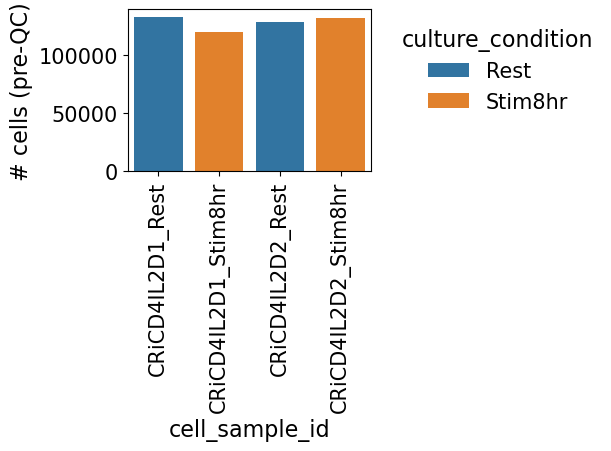

In [10]:
qc_plots.plot_ncells_sample(adata);
save_plot(f'{experiment_name}_n_cells_preQC')

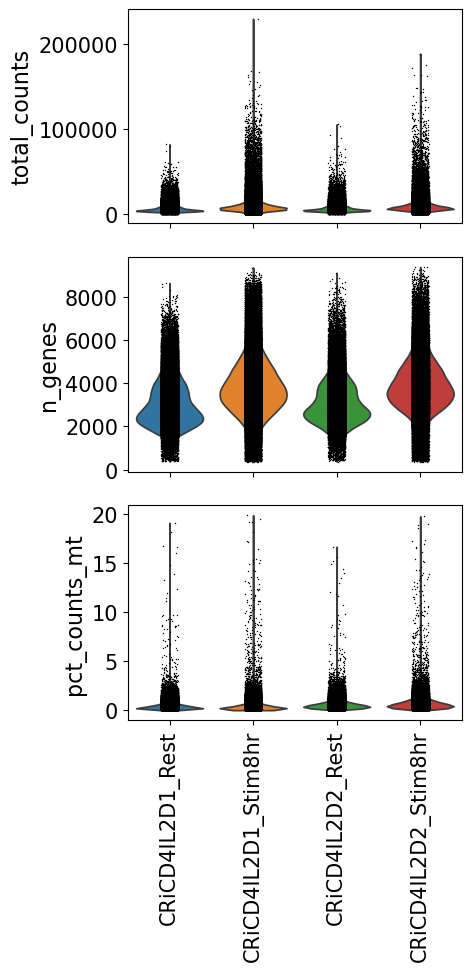

In [12]:
fig, axs = plt.subplots(3,1, figsize=(5,10))
for i,m in enumerate(['total_counts', 'n_genes', 'pct_counts_mt']):
    sc.pl.violin(adata, m, groupby='cell_sample_id', rotation=90, show=False, ax=axs[i]);
    if i != 2:
        # remove x-axis tick labels
        axs[i].set_xticklabels([])

fig.tight_layout()
fig.show()


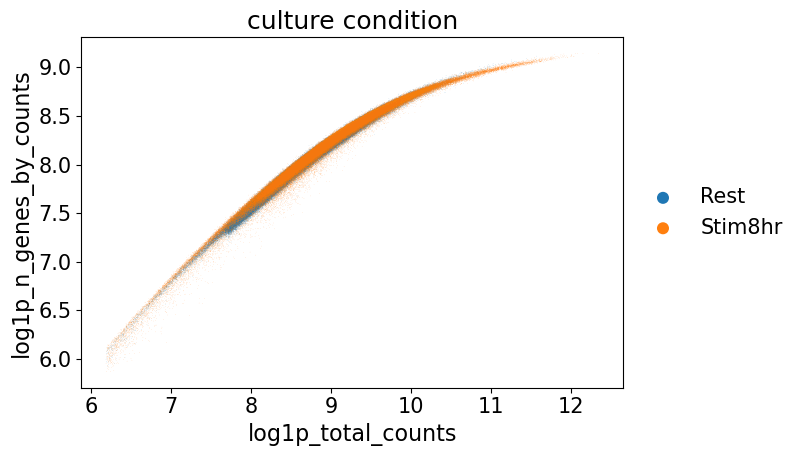

In [13]:
sc.pl.scatter(adata, 'log1p_total_counts', 'log1p_n_genes_by_counts', color='culture_condition')

In [14]:
adata.obs[['total_counts', 'n_genes', 'pct_counts_mt', "cell_sample_id"]].groupby("cell_sample_id").mean()

total_counts      n_genes  pct_counts_mt
cell_sample_id                                               
CRiCD4IL2D1_Rest      6643.590820  3065.600214       0.393316
CRiCD4IL2D1_Stim8hr  10262.543945  3826.303324       0.382195
CRiCD4IL2D2_Rest      6708.548340  3150.183217       0.548406
CRiCD4IL2D2_Stim8hr   9903.507812  3907.569363       0.653896

Estimate fraction of low quality cells (high fraction of mitochondrial genes, low number of captured genes)

In [15]:
adata.obs['low_quality'] = (adata.obs['pct_counts_mt'] > 5) | (adata.obs['n_genes'] < 1000)

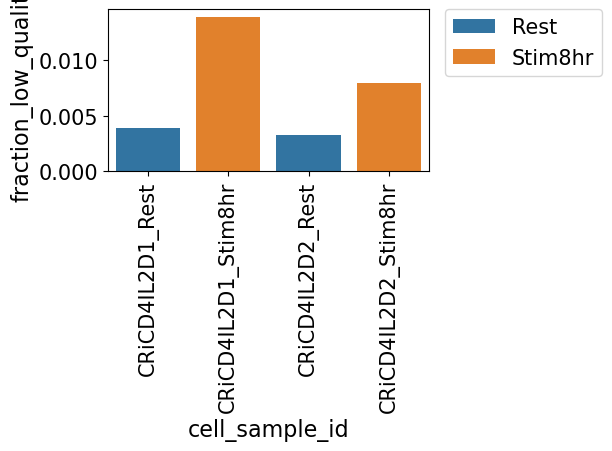

In [16]:
# plot fraction of low_quality cells for each sample_id
low_quality_df = adata.obs.groupby(["cell_sample_id", 'culture_condition'])['low_quality'].mean().reset_index(name='fraction_low_quality')
low_quality_df
sns.barplot(data=low_quality_df, x="cell_sample_id", y='fraction_low_quality', hue='culture_condition', dodge=False);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.xticks(rotation=90);


## sgRNA assignment QC metrics

In [17]:
import upsetplot
from upsetplot import from_contents

In [19]:
all_crispr_a = {}
for sample_id in sample_metadata["library_id"]:
    sgrna_h5ad = f"{datadir}{sample_id}.sgRNA.h5ad"
    crispr_a = sc.read_h5ad(sgrna_h5ad)
    all_crispr_a[sample_id] = crispr_a

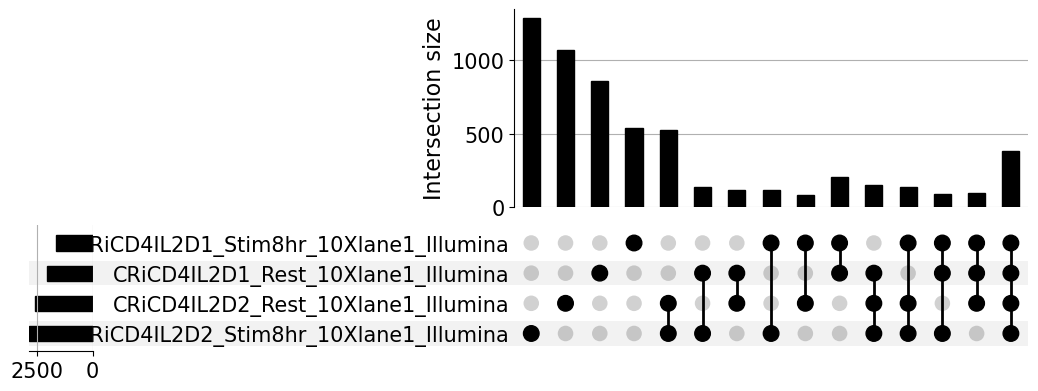

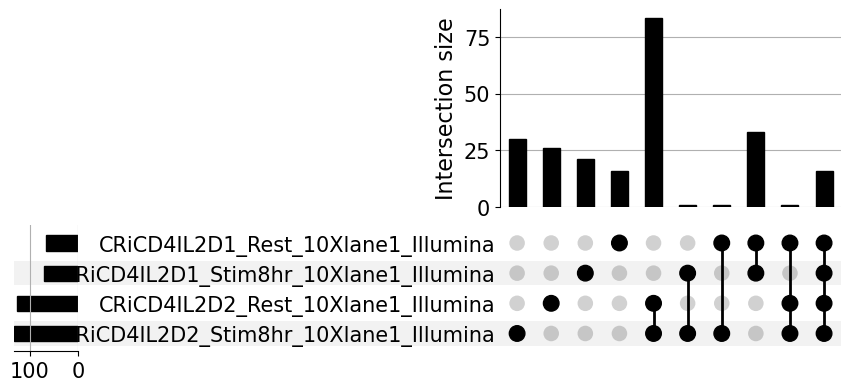

In [20]:
# Get lists of inefficient and nonspecific guides for each sample
all_inefficient = {k:x.var_names[x.var['inefficient']].tolist() for k,x in all_crispr_a.items()}
all_nonspecific = {k:x.var_names[x.var['nonspecific']].tolist() for k,x in all_crispr_a.items()}

inef = from_contents(all_inefficient)
ax_dict = upsetplot.UpSet(inef, subset_size="count").plot()

nons = from_contents(all_nonspecific)
ax_dict = upsetplot.UpSet(nons).plot()

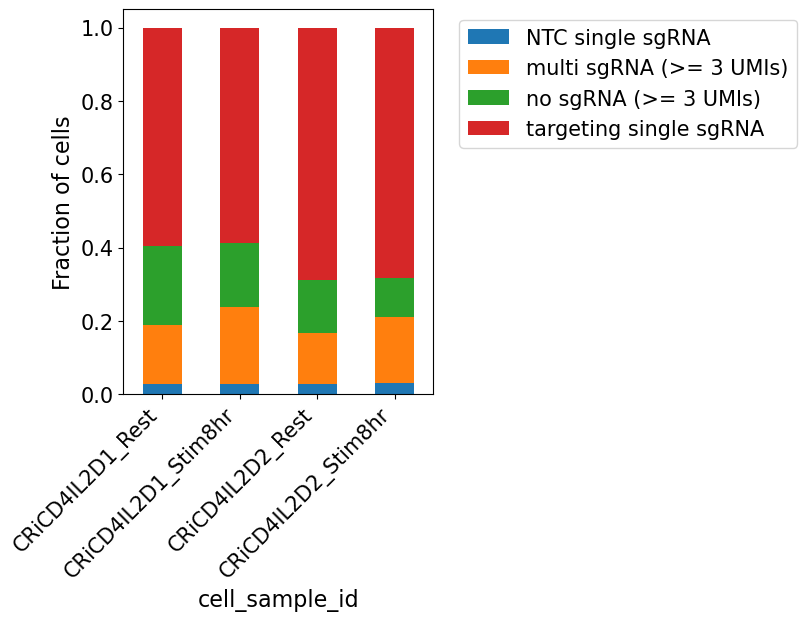

In [22]:
pl_df = adata.obs[['guide_id', "cell_sample_id", 'low_quality']]
pl_df['group'] = 'targeting single sgRNA'
pl_df['group'] = np.where(adata.obs['guide_id'].str.startswith('NTC'), 'NTC single sgRNA', pl_df['group'])
pl_df['group'] = np.where(adata.obs['guide_id'].isna(), 'no sgRNA (>= 3 UMIs)', pl_df['group'])
pl_df['group'] = np.where(adata.obs['guide_id']  == 'multi_sgRNA', 'multi sgRNA (>= 3 UMIs)', pl_df['group'])
pl_df = pl_df[~pl_df['low_quality']].copy()
# Plot stacked barplot of fraction of cells in each group for each sample

group_counts = pl_df.groupby(["cell_sample_id", 'group']).size().unstack()
group_fractions = group_counts.div(group_counts.sum(axis=1), axis=0)
group_fractions.plot(kind='bar', stacked=True, figsize=(4,5))
plt.xticks(rotation=45, ha='right')
plt.ylabel('Fraction of cells')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

In [23]:
group_counts

group                NTC single sgRNA  multi sgRNA (>= 3 UMIs)  \
cell_sample_id                                                   
CRiCD4IL2D1_Rest                 3585                    21576   
CRiCD4IL2D1_Stim8hr              3256                    24818   
CRiCD4IL2D2_Rest                 3730                    17739   
CRiCD4IL2D2_Stim8hr              3847                    23546   

group                no sgRNA (>= 3 UMIs)  targeting single sgRNA  
cell_sample_id                                                     
CRiCD4IL2D1_Rest                    28233                   78970  
CRiCD4IL2D1_Stim8hr                 20597                   69410  
CRiCD4IL2D2_Rest                    18416                   87865  
CRiCD4IL2D2_Stim8hr                 14004                   88946

In [51]:
# no_guide_cells = adata.obs_names[adata.obs['guide_id'].isna()]
# multi_guide_cells = adata.obs_names[adata.obs['guide_id'] == 'multi_sgRNA']

# fig, axes = plt.subplots(1, 4, figsize=(20, 5))
# for i, (sample_id, crispr_a) in enumerate(all_crispr_a.items()):
#     crispr_a.obs['multi_sgrna'] = crispr_a.obs_names.isin(multi_guide_cells)
#     crispr_a.obs['no_sgrna'] = crispr_a.obs_names.isin(no_guide_cells)
#     crispr_a.obs['targeting_umis'] = np.array(crispr_a[:, crispr_a.var['sgrna_type'] == 'targeting'].X.sum(axis=1)).flatten()
#     crispr_a.obs['ntc_umis'] = np.array(crispr_a[:, crispr_a.var['sgrna_type'] == 'NTC'].X.sum(axis=1)).flatten()
#     crispr_a.obs['inefficient_umis'] = np.array(crispr_a[:, crispr_a.var['inefficient']].X.sum(axis=1)).flatten()
#     crispr_a.obs['nonspecific_umis'] = np.array(crispr_a[:, crispr_a.var['nonspecific']].X.sum(axis=1)).flatten()

#     ntc_n = sum(no_sgrna_a.obs['ntc_umis'] > 3)
#     tot_n = no_sgrna_a.n_obs
#     subtitle = f'{ntc_n}/{tot_n} multi sgRNA cells with NTC sgRNAs'
#     no_sgrna_a = crispr_a[crispr_a.obs['multi_sgrna']].copy()
    
#     axes[i].scatter(no_sgrna_a.obs['ntc_umis'], no_sgrna_a.obs['targeting_umis'], s=3)
#     axes[i].set_xscale('log')
#     axes[i].set_yscale('log')
#     axes[i].set_xlabel('NTC sgRNA UMI counts')
#     axes[i].set_ylabel('Targeting sgRNA UMI counts')
#     axes[i].set_title('Multi sgRNA cells - ' + crispr_a.obs["cell_sample_id"][0] + '\n' + subtitle)

# plt.tight_layout()
# plt.show()

## Dimensionality reduction

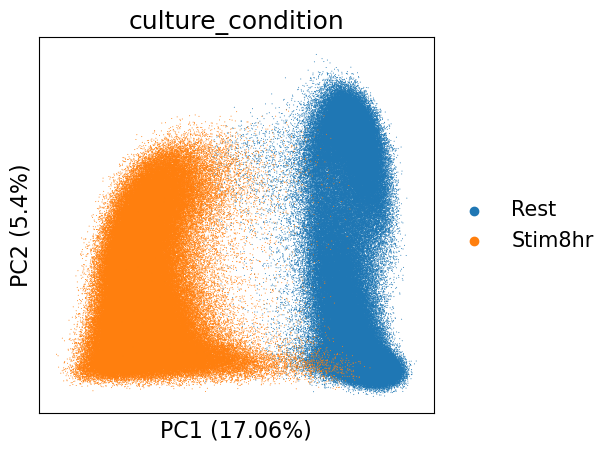

In [24]:
sc.pl.pca(adata, annotate_var_explained=True, color=['culture_condition'], components=['1,2'], wspace=0.5, ncols=3, size=2)

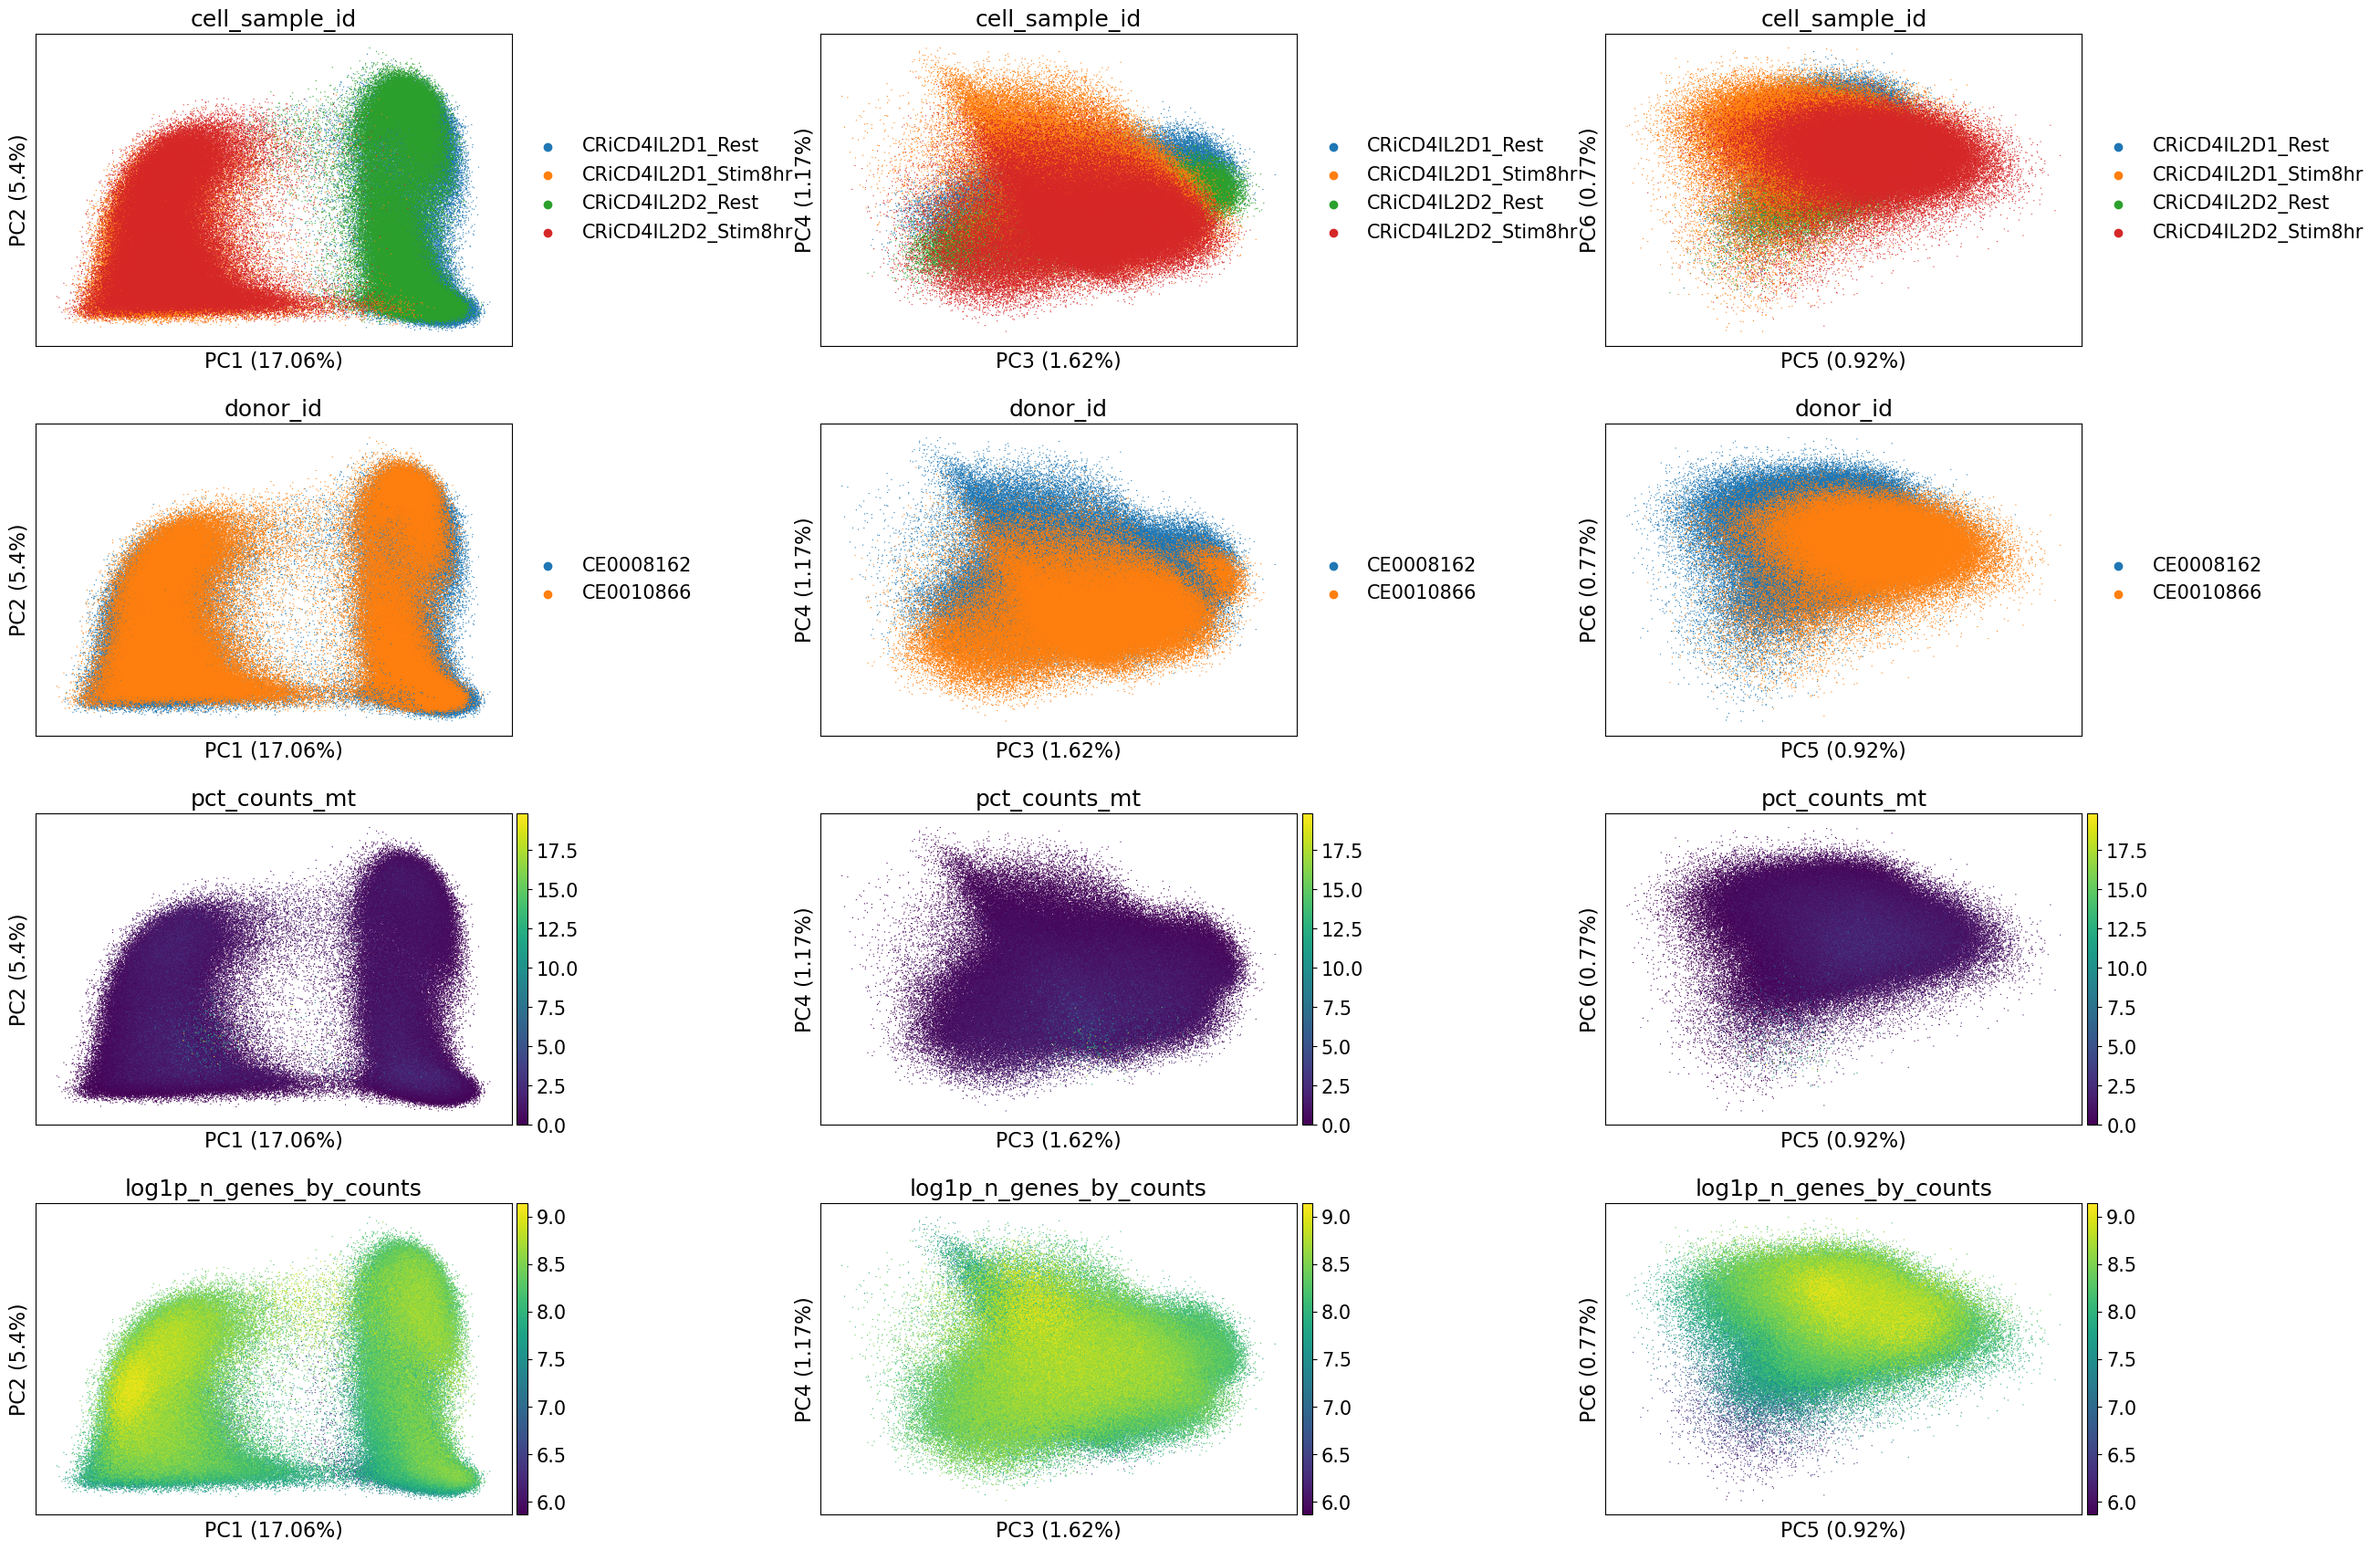

In [26]:
sc.pl.pca(adata, annotate_var_explained=True, color=["cell_sample_id", "donor_id", 'pct_counts_mt', 'log1p_n_genes_by_counts'], components=['1,2', '3,4', '5,6'], wspace=0.5, ncols=3, size=3)

Visualize genes with top loadings for each PC

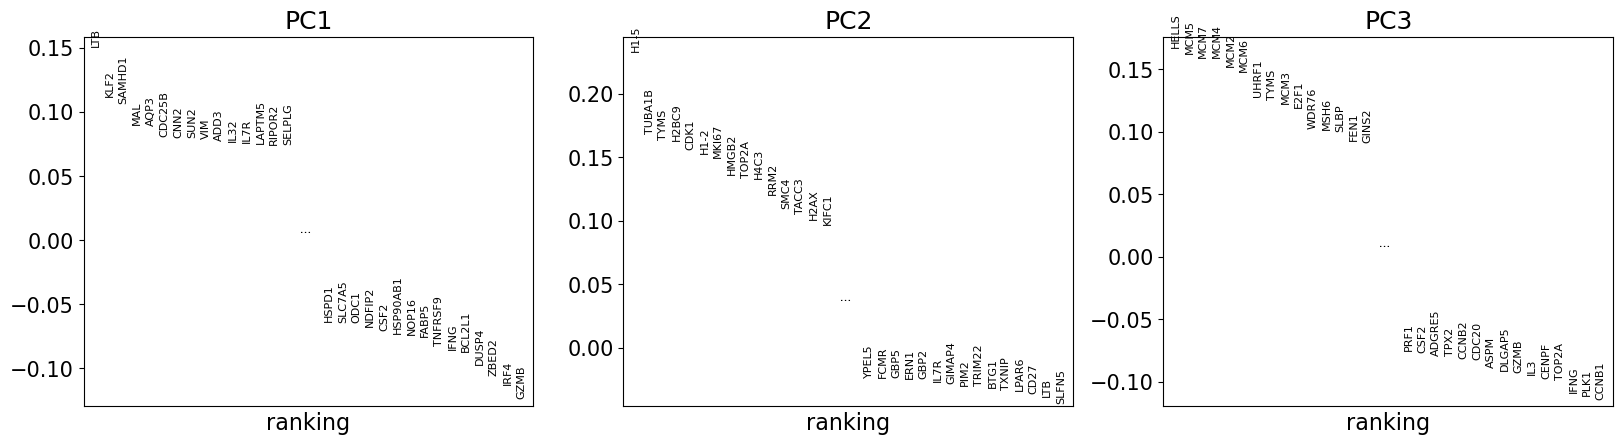

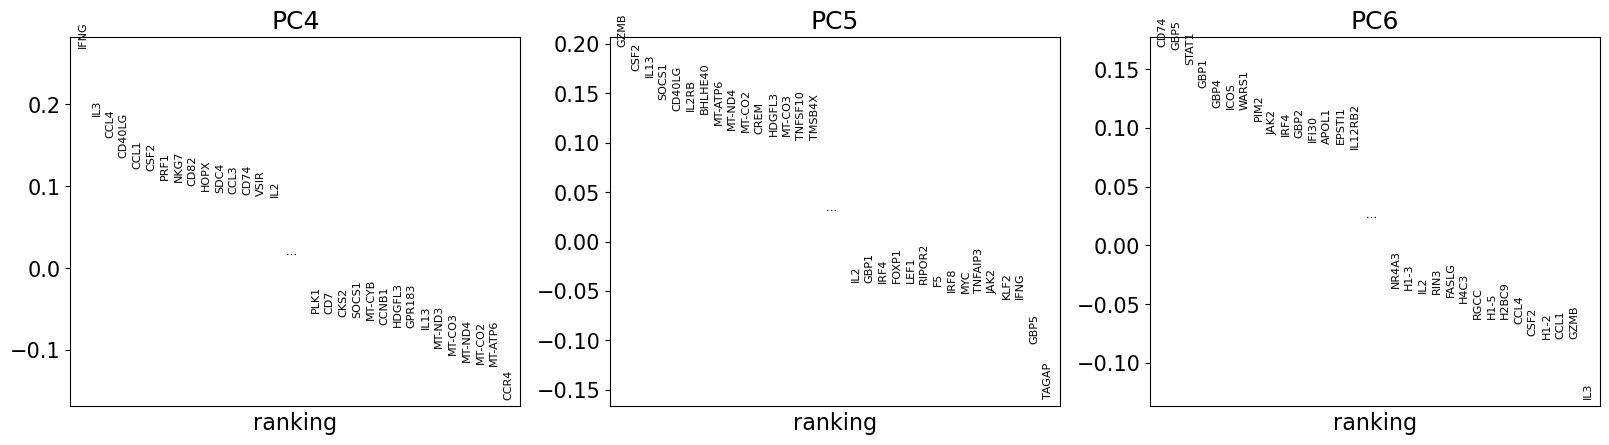

In [27]:
sc.pl.pca_loadings(adata, components='1,2,3');
sc.pl.pca_loadings(adata, components='4,5,6')

## Clustering

In [28]:
rsc.pp.neighbors(adata, n_neighbors=50)
rsc.tl.umap(adata)
rsc.tl.louvain(adata)

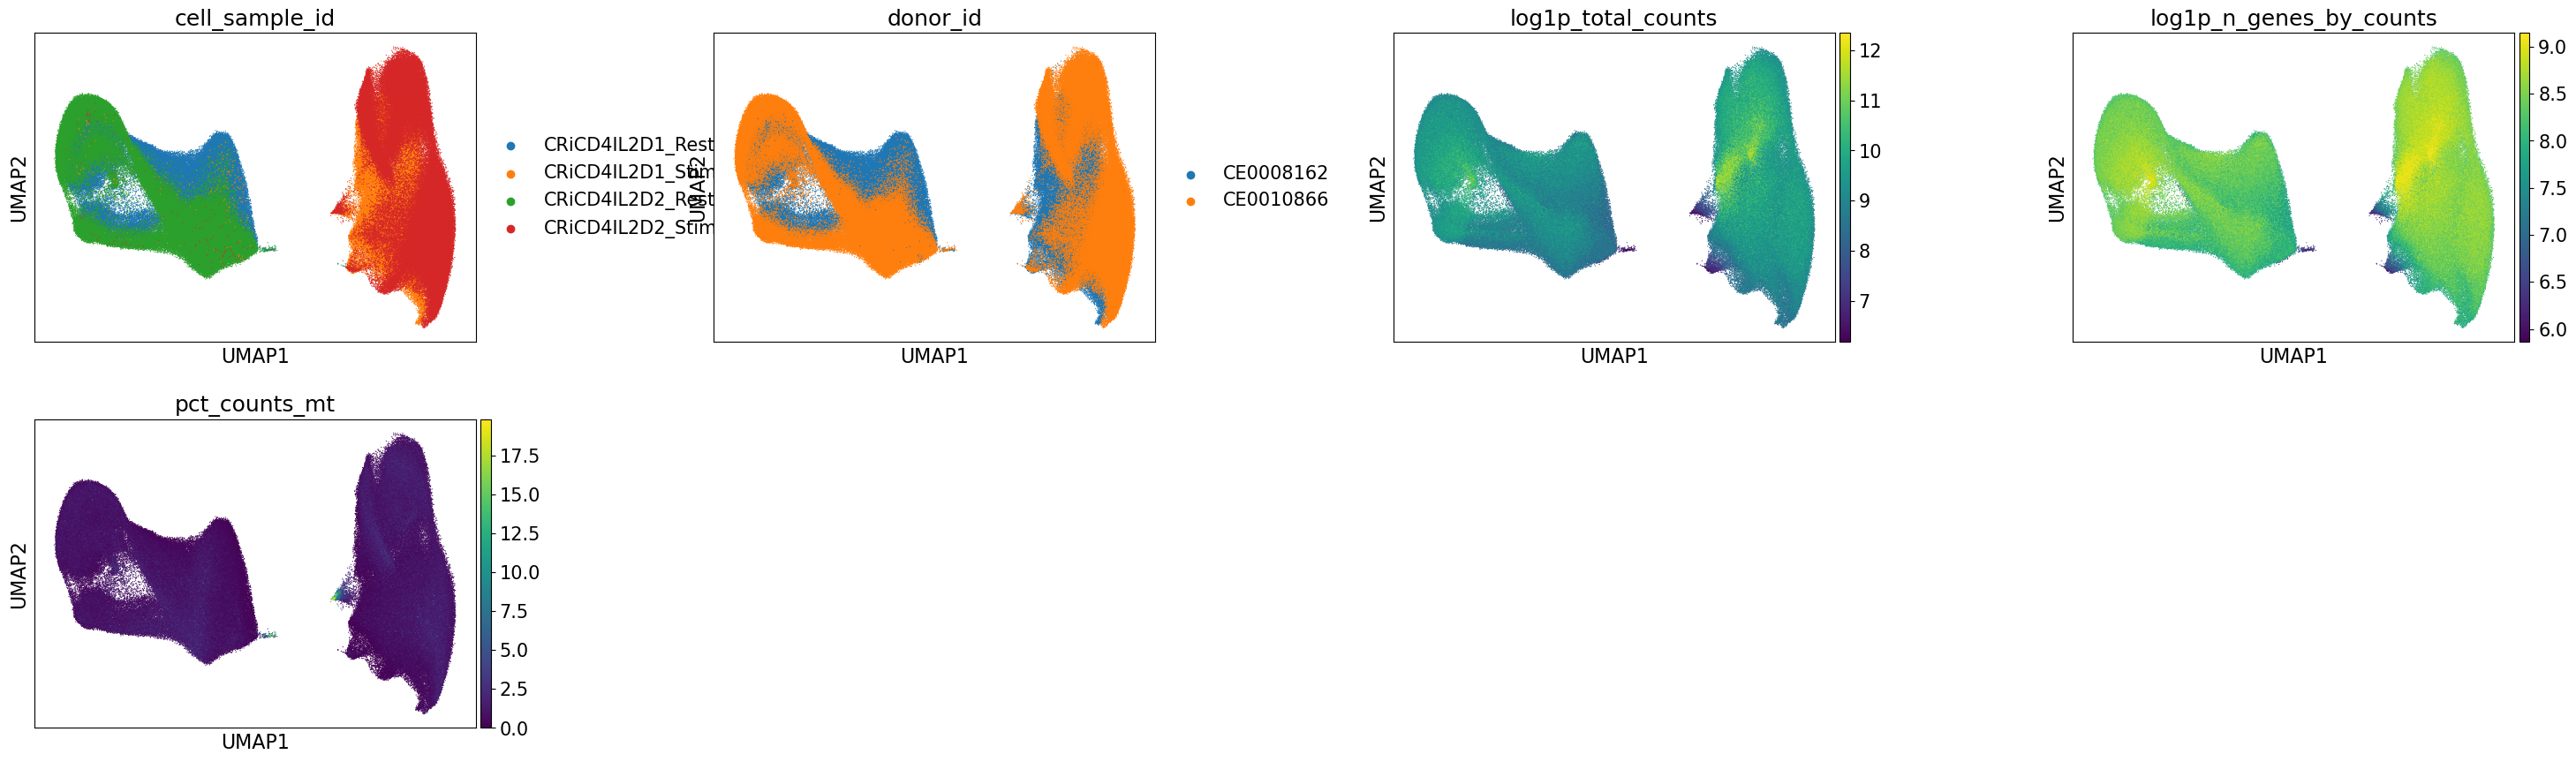

In [31]:
sc.pl.umap(adata, color=["cell_sample_id", 'donor_id'] + ['log1p_total_counts','log1p_n_genes_by_counts','pct_counts_mt'], wspace=0.4, size=3)

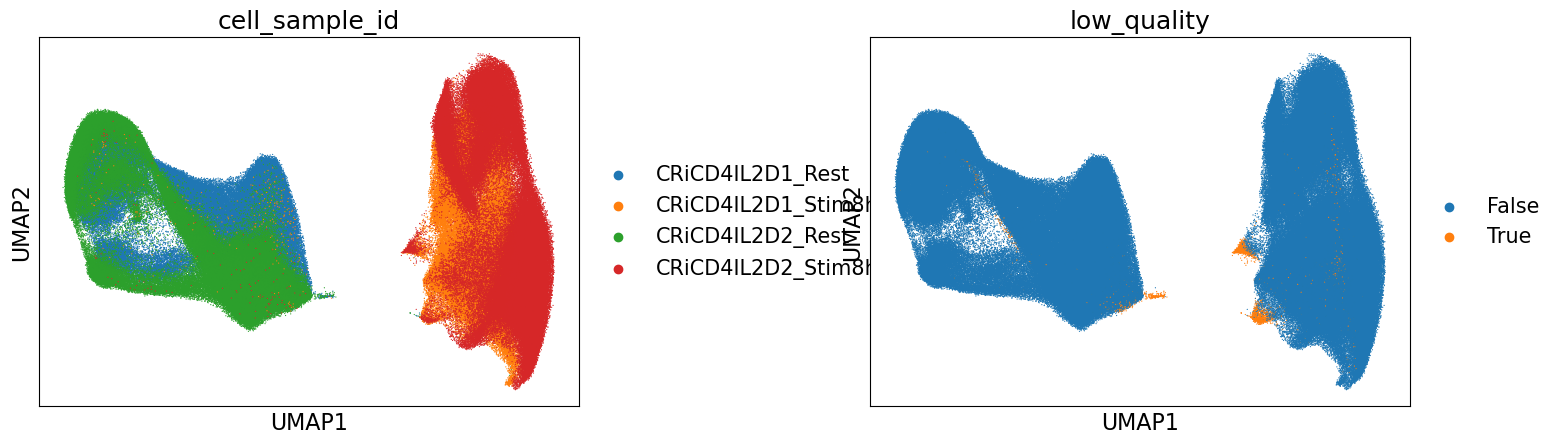

In [30]:
sc.pl.umap(adata, color=["cell_sample_id"] + ['low_quality'], wspace=0.4, size=3)

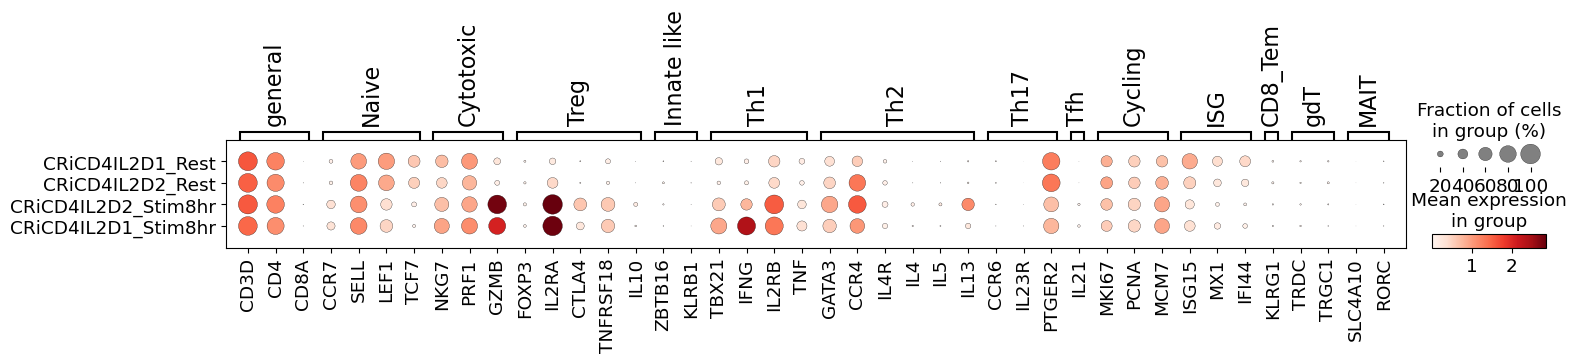

In [32]:
qc_plots.plot_markers_sample_dotplot(adata, save=f'{experiment_name}_markers_sample_dotplot')

In [33]:
# qc_plots.plot_markers_umap(adata, wspace=0.1, size=3, cmap='magma', ncols=5, save=f'{experiment_name}_markers.png')

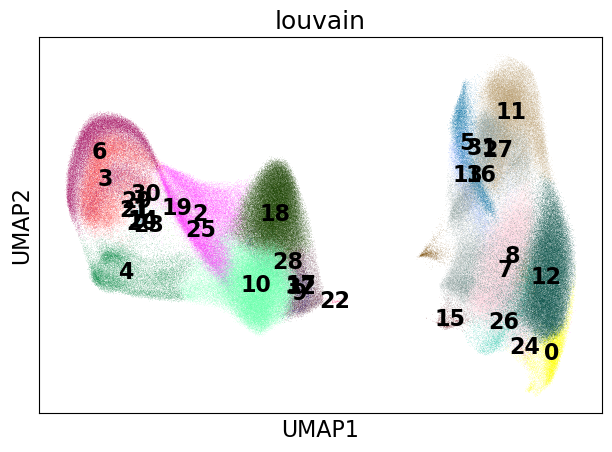

In [34]:
sc.pl.umap(adata, color='louvain', legend_loc='on data')

<Axes: xlabel='louvain', ylabel='pct_counts_mt'>

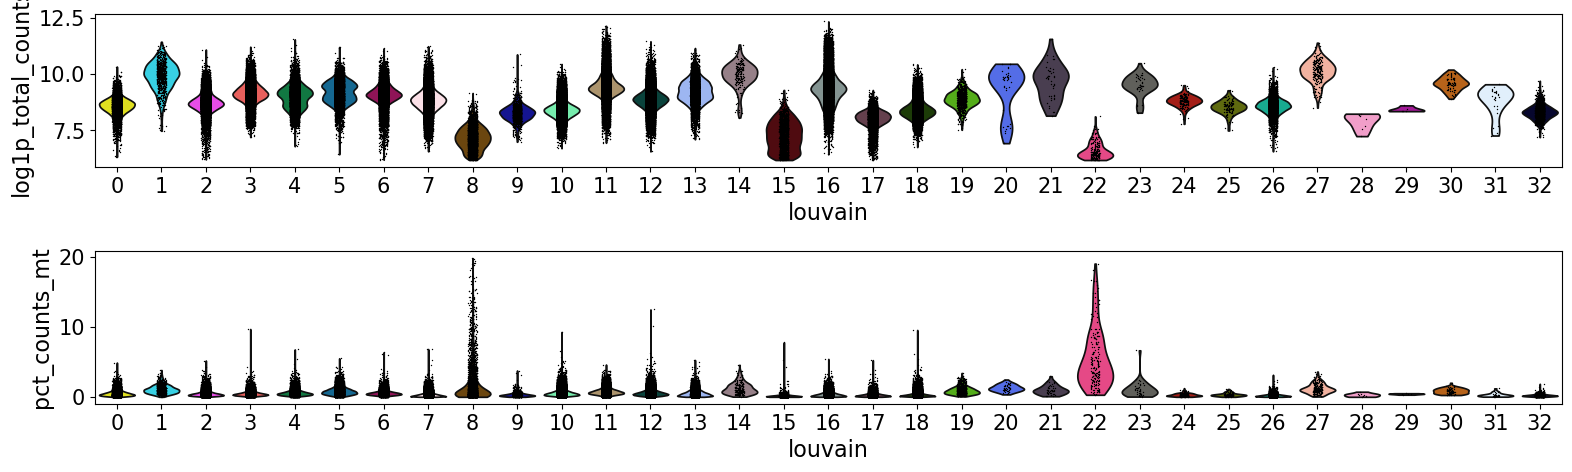

In [41]:
fig,axs = plt.subplots(2,1,figsize=(16, 5))
sc.pl.violin(adata, ['log1p_total_counts'], groupby='louvain', ax=axs[0], show=False)
sc.pl.violin(adata, ['pct_counts_mt'], groupby='louvain', ax=axs[1], show=False)

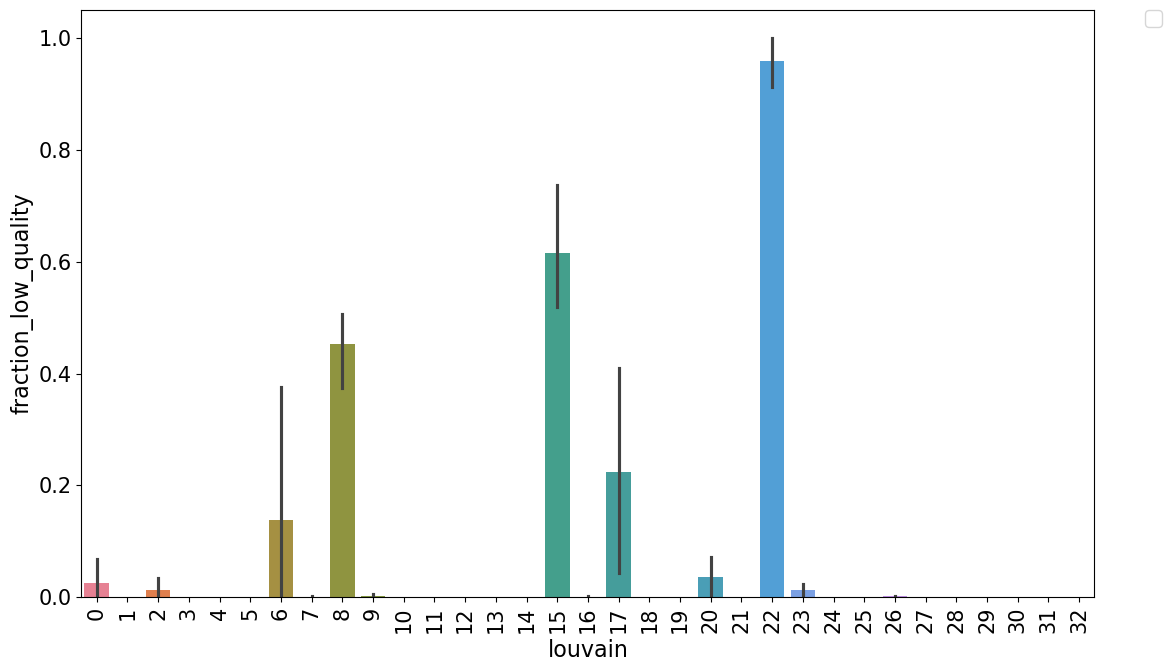

In [42]:
# plot fraction of low_quality cells for each cluster
low_quality_df = adata.obs.groupby(["cell_sample_id", 'louvain'])['low_quality'].mean().reset_index(name='fraction_low_quality')

plt.figure(figsize=(12,7))
sns.barplot(data=low_quality_df, x='louvain', y='fraction_low_quality', hue='louvain', dodge=False);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.xticks(rotation=90);

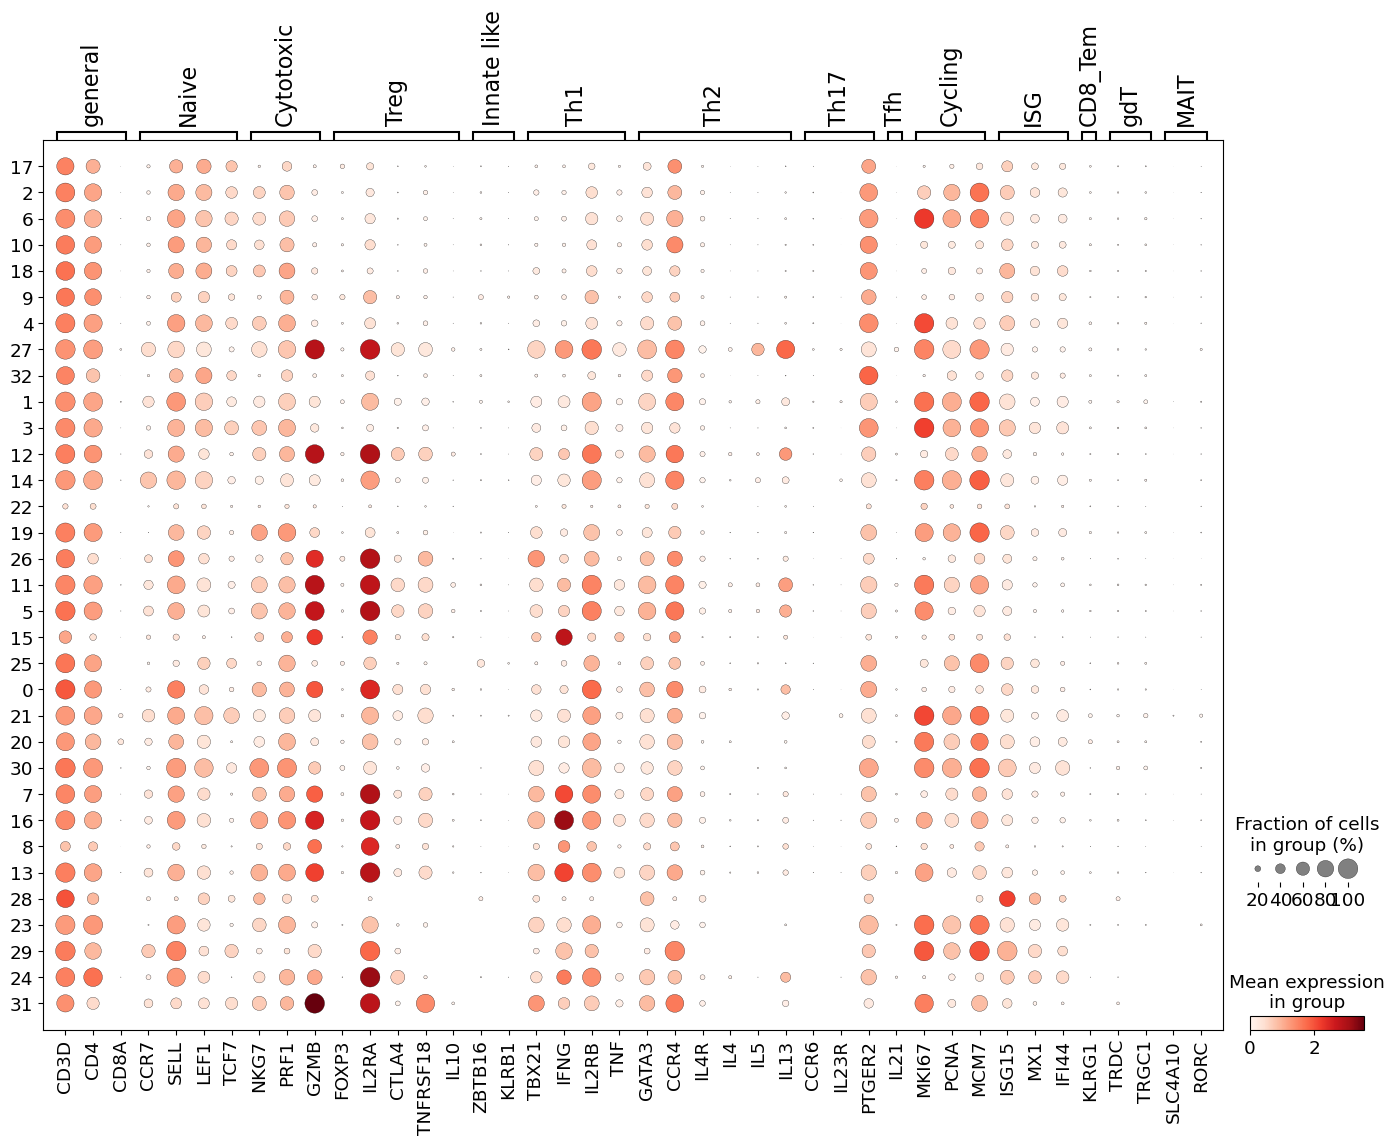

In [43]:
group_by = 'culture_condition'
markers_dict = qc_plots.load_Tcell_markers(adata)
order_samples = adata.obs.sort_values([group_by])['louvain'].astype(str).unique()
adata.obs['louvain'] = adata.obs['louvain'].cat.reorder_categories(order_samples)
sc.pl.dotplot(adata, markers_dict, groupby='louvain')


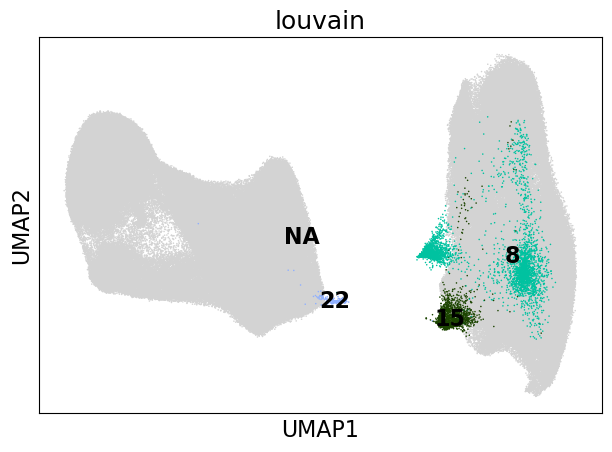

In [44]:
low_quality_clusters = ['15', '8', '22']
sc.pl.umap(adata, color='louvain', legend_loc='on data', size=5, groups=low_quality_clusters)

In [45]:
adata_postqc = adata[~adata.obs['louvain'].isin(low_quality_clusters)].copy()

In [46]:
adata_postqc.write_h5ad(f'{datadir}/{experiment_name}_merged.gex.lognorm.postQC.h5ad')

## Knock-down efficiency

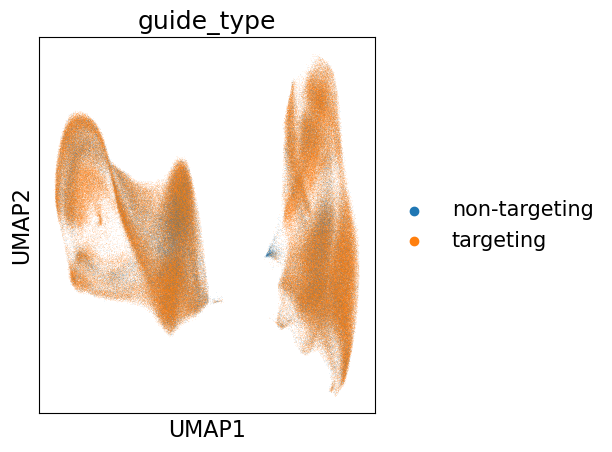

In [47]:
sc.pl.umap(adata, color='guide_type')

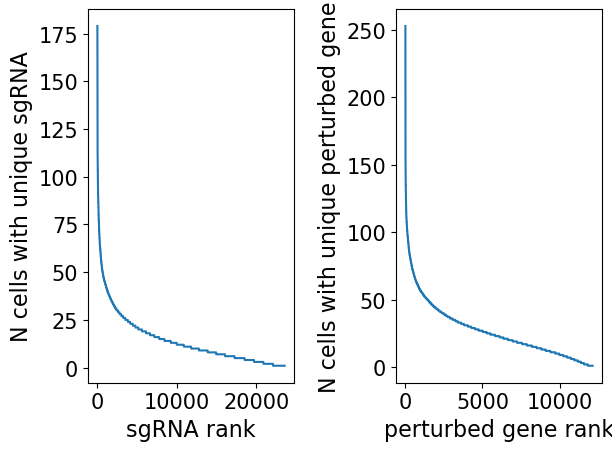

In [48]:
guide_cell_counts = adata.obs['guide_id'].value_counts()
guide_cell_counts.index = guide_cell_counts.index.astype(str)
plt.subplot(1,2,1);
plt.plot(guide_cell_counts[1:].values);
plt.xlabel('sgRNA rank');
plt.ylabel('N cells with unique sgRNA');


gene_cell_counts = adata.obs['perturbed_gene_name'].value_counts()
gene_cell_counts.index = gene_cell_counts.index.astype(str)

plt.subplot(1,2,2);
plt.plot(gene_cell_counts[1:].values);
plt.xlabel('perturbed gene rank');
plt.ylabel('N cells with unique perturbed gene');

In [49]:
perturbed_gene_expr_df = qc_plots.calculate_perturbed_gene_expression(adata)
kd_results_c = qc_plots.test_knockdown_simple(perturbed_gene_expr_df)

In [50]:
kd_results_c['signif_knockdown'].value_counts().sum()

12147

In [51]:
kd_results_c.to_csv(f'{datadir}/knockdown_efficacy_simple.csv')

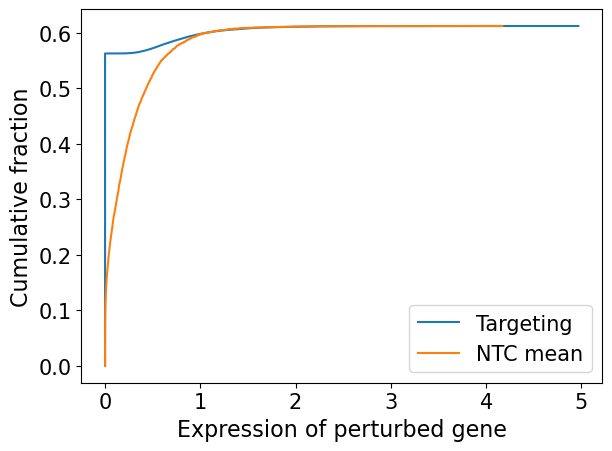

In [52]:
# Plot cumulative distributions
plt.plot(np.sort(perturbed_gene_expr_df['perturbed_gene_expr']),
         np.linspace(0, 1, len(perturbed_gene_expr_df['perturbed_gene_expr'])), label='Targeting')
plt.plot(np.sort(perturbed_gene_expr_df['perturbed_gene_mean_ntc']),
         np.linspace(0, 1, len(perturbed_gene_expr_df['perturbed_gene_mean_ntc'])), label='NTC mean')
plt.xlabel('Expression of perturbed gene');
plt.ylabel('Cumulative fraction');
plt.legend()

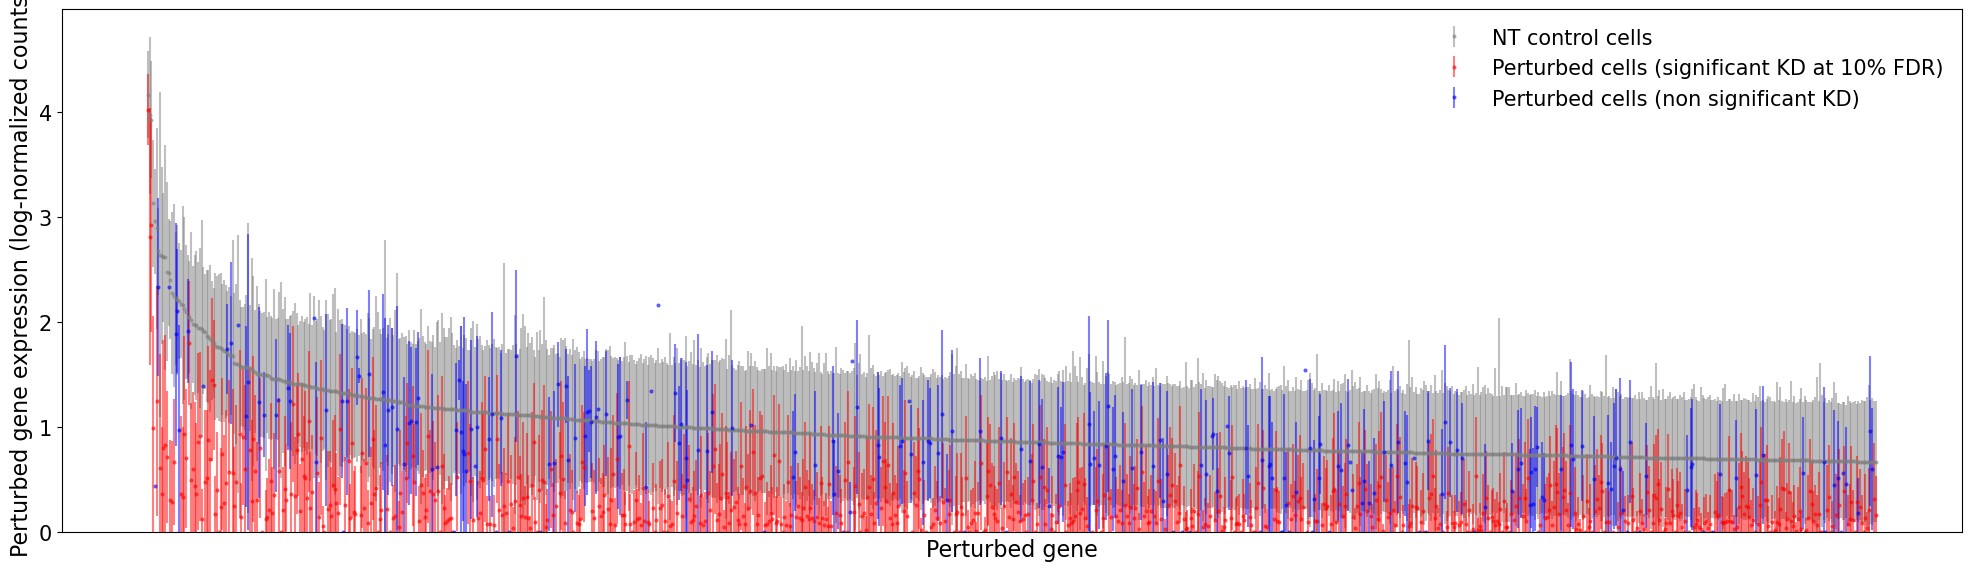

In [54]:
mean_perturbed_gene_expr_df = kd_results_c
order_genes = mean_perturbed_gene_expr_df.sort_values('perturbed_gene_mean_ntc', ascending=False).perturbed_gene.astype(str).values
mean_perturbed_gene_expr_df['perturbed_gene'] = pd.Categorical(mean_perturbed_gene_expr_df['perturbed_gene'], categories=order_genes, ordered=True)

pl_df = mean_perturbed_gene_expr_df[mean_perturbed_gene_expr_df['perturbed_gene'].isin(order_genes[0:1000])].sort_values('perturbed_gene')
plt.figure(figsize=(20,6))
# Plot mean NTC expression with error bars
plt.errorbar(pl_df['perturbed_gene'],
             pl_df['perturbed_gene_mean_ntc'], 
             yerr=pl_df['perturbed_gene_std_ntc'],
             fmt='o',
             color='grey',
             markersize=2,
             alpha=0.5,
             label='NT control cells')

# Add stripplot of perturbed expression
plt.errorbar(pl_df[pl_df.signif_knockdown]['perturbed_gene'],
           pl_df[pl_df.signif_knockdown]['perturbed_gene_expr'],
           yerr=pl_df[pl_df.signif_knockdown]['perturbed_gene_expr_std'],
           fmt='o',
           markersize=2,
           color='red',
           alpha=0.5,
           label='Perturbed cells (significant KD at 10% FDR)')
plt.errorbar(pl_df[~pl_df.signif_knockdown]['perturbed_gene'],
           pl_df[~pl_df.signif_knockdown]['perturbed_gene_expr'],
           yerr=pl_df[~pl_df.signif_knockdown]['perturbed_gene_expr_std'],
           fmt='o',
           markersize=2,
           color='blue',
           alpha=0.5,
           label='Perturbed cells (non significant KD)')

plt.xticks([])
plt.ylim(0)
plt.xlabel('Perturbed gene')
plt.ylabel('Perturbed gene expression (log-normalized counts)')
plt.legend(frameon=False);
plt.tight_layout()

Text(0, 0.5, 'Perturbed gene expression (log-normalized counts)')

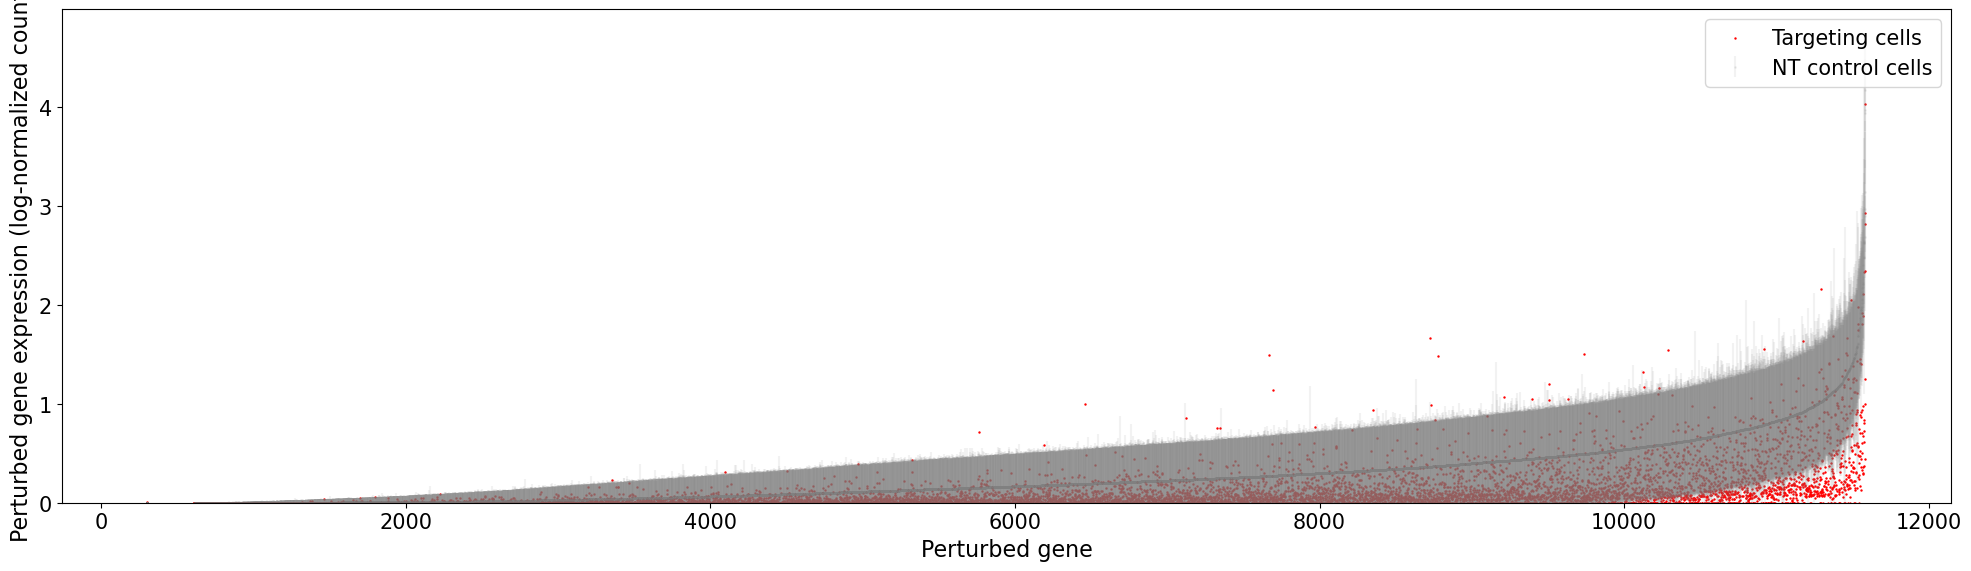

In [55]:
plt.figure(figsize=(20,6))
mean_perturbed_gene_expr_df['rank'] = mean_perturbed_gene_expr_df['perturbed_gene_mean_ntc'].rank()
# # Plot mean NTC expression with error bars
plt.errorbar(mean_perturbed_gene_expr_df['rank'],
             mean_perturbed_gene_expr_df['perturbed_gene_mean_ntc'], 
             yerr=mean_perturbed_gene_expr_df['perturbed_gene_std_ntc'],
             fmt='o',
             color='grey',
             markersize=1, 
             alpha=0.1,
             label='NT control cells')

sns.scatterplot(y=mean_perturbed_gene_expr_df['perturbed_gene_expr'], x=mean_perturbed_gene_expr_df['perturbed_gene_mean_ntc'].rank(), s=3, label='Targeting cells', color='red', linewidth=0);
plt.ylim(0)
plt.xlabel('Perturbed gene')
plt.ylabel('Perturbed gene expression (log-normalized counts)')


In [56]:
all_conditions = adata.obs['culture_condition'].unique()
all_conditions_tests = {}
for c in all_conditions:
    print(c)
    ad_c = adata[adata.obs['culture_condition'] == c].copy()
    perturbed_gene_expr_df = qc_plots.calculate_perturbed_gene_expression(ad_c)
    kd_results_c = qc_plots.test_knockdown_simple(perturbed_gene_expr_df)
    kd_results_c['culture_condition'] = c
    all_conditions_tests[c] = kd_results_c

Rest
Stim8hr


In [57]:
for k in all_conditions_tests.keys():
    print(all_conditions_tests[k].signif_knockdown.value_counts())

signif_knockdown
True     7837
False    4001
Name: count, dtype: int64
signif_knockdown
True     7823
False    4083
Name: count, dtype: int64


## Check Puro spike-in

In [67]:
os.listdir(datadir)

['CRiCD4IL2_Illumina_merged.gex.lognorm.postQC.h5ad',
 'CRiCD4IL2D2_Stim8hr_10Xlane1_Illumina.sgRNA.h5ad',
 'CRiCD4IL2_Illumina_merged.gex.lognorm.h5ad',
 'knockdown_efficacy_simple.csv',
 'sgrna_assignment.csv',
 'CRiCD4IL2D1_Stim8hr_10Xlane1_Illumina.sgRNA.h5ad',
 'tmp',
 'CRiCD4IL2D1_Rest_10Xlane1_Illumina.sgRNA.h5ad',
 'cellranger_outs',
 'CRiCD4IL2D2_Rest_10Xlane1_Illumina.sgRNA.h5ad']

In [68]:
s_ad = sc.read_h5ad(datadir + 'CRiCD4IL2D1_Rest_10Xlane1_Illumina.sgRNA.h5ad')
s_ad

AnnData object with n_obs × n_vars = 132898 × 27272
    obs: 'library_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'sgrna_id', 'perturbed_gene_name', 'perturbation_type', 'sgrna_type', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mean_counts', 'total_counts', 'nonz_means', 'n_cells_outlier', 'inefficient', 'nonspecific'

In [96]:
s_ad = sc.read_10x_h5('/mnt/oak/users/emma/data/GWT/CRiCD4IL2/lane13_10x/CRiCD4IL2D2_Rest_sample_filtered_feature_bc_matrix.h5')
s_ad.var['gene_ids'].str.startswith('ENS').all()

True

In [103]:
[x for x in s_ad.var_names if 'Puro' in x or 'PURO' in x or 'CUSTOM' in x or 'PuroR' in x]

[]